<div class="alert alert-block alert-success">
    <b><center>Pytorch LIBRARY</center></b>
    <b><center>CIFAR 10 Advanced</center></b>
</div>

# Configure Learning Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Prepare Data

In [4]:
# !git clone https://github.com/jaddoescad/ants_and_bees
# !mv ants_and_bees/* datas
# !rm -rf ants_and_bees

In [5]:
augumentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])
res_train = datasets.ImageFolder("./datas/train", transform=augumentation)
res_valid = datasets.ImageFolder("./datas/val", transform=transform)

In [7]:
len(res_train), len(res_valid)

(244, 153)

In [8]:
load_train = torch.utils.data.DataLoader(res_train, batch_size=20, shuffle=True)
load_valid = torch.utils.data.DataLoader(res_valid, batch_size=20, shuffle=True)

In [9]:
iter_train = iter(load_train)
images, labels = iter_train.next()
images.shape, labels.shape

(torch.Size([20, 3, 224, 224]), torch.Size([20]))

In [10]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 255)
    return image

In [11]:
class_names = ["ant", "bee"]

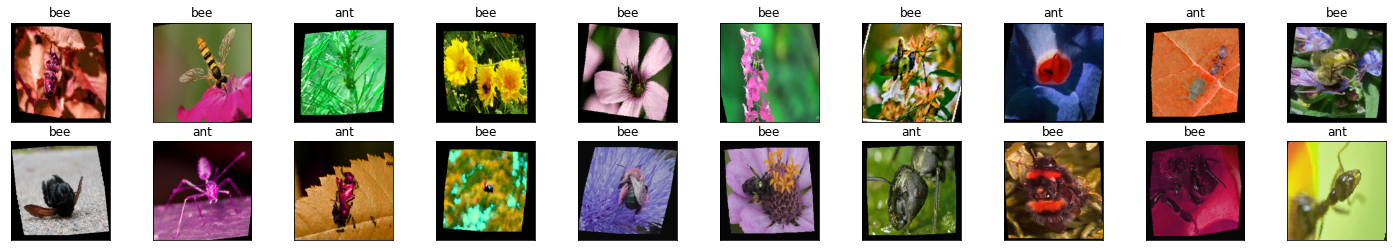

In [12]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(class_names[labels[idx].item()])

# Generate Model

In [13]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
last_input = model.classifier[6].in_features
model.classifier[6] = nn.Linear(last_input, len(class_names))
model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
fn_loss = nn.CrossEntropyLoss()
fn_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training

In [17]:
epochs = 10
size_bunch_train = len(load_train)
size_bunch_valid = len(load_valid)

In [18]:
history = []
for epoch in range(epochs):
    loss_learns, accu_learns, loss_valids, accu_valids = .0, .0, .0, .0

    # Learning Step
    for datas, labels in load_train:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # backpropagation
        fn_optimizer.zero_grad()
        loss.backward()
        fn_optimizer.step()
        
        # Caculating loss/accuracy for monitoring
        loss_learns += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_learns += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    # Validating Step
    for datas, labels in load_valid:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # Caculating loss/accuracy for monitoring
        loss_valids += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_valids += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    loss_learn = loss_learns / size_bunch_train
    accu_learn = accu_learns / size_bunch_train
    loss_valid = loss_valids / size_bunch_valid
    accu_valid = accu_valids / size_bunch_valid
    history.append({"loss": loss_learn, "accuracy": accu_learn, "validation loss": loss_valid, "validation accuracy": accu_valid})
    
    print(f"{epoch+1:02d} step -> loss: {loss_learn:.4f}, accuracy: {accu_learn:.2f} %, validation loss: {loss_valid:.4f}, validation accuracy: {accu_valid:.2f} %")

01 step -> loss: 0.5239, accuracy: 72.69 %, validation loss: 0.2634, validation accuracy: 89.04 %
02 step -> loss: 0.2904, accuracy: 90.00 %, validation loss: 0.2753, validation accuracy: 90.29 %
03 step -> loss: 0.2145, accuracy: 91.15 %, validation loss: 0.2595, validation accuracy: 90.91 %
04 step -> loss: 0.1031, accuracy: 95.38 %, validation loss: 0.2871, validation accuracy: 92.16 %
05 step -> loss: 0.0690, accuracy: 97.69 %, validation loss: 0.3462, validation accuracy: 91.83 %
06 step -> loss: 0.0739, accuracy: 95.77 %, validation loss: 0.3788, validation accuracy: 91.25 %
07 step -> loss: 0.0721, accuracy: 97.31 %, validation loss: 0.3444, validation accuracy: 93.12 %
08 step -> loss: 0.0516, accuracy: 97.31 %, validation loss: 0.3402, validation accuracy: 91.83 %
09 step -> loss: 0.1125, accuracy: 96.92 %, validation loss: 0.2749, validation accuracy: 92.50 %
10 step -> loss: 0.0540, accuracy: 97.69 %, validation loss: 0.4667, validation accuracy: 89.33 %


In [19]:
df_history = pd.DataFrame.from_records(history)

<AxesSubplot:>

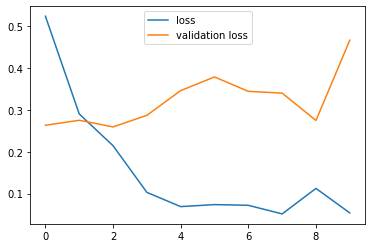

In [20]:
df_history[["loss", "validation loss"]].plot()

<AxesSubplot:>

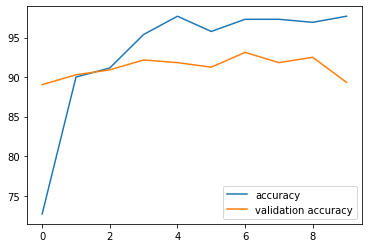

In [21]:
df_history[["accuracy", "validation accuracy"]].plot()

# Prediction

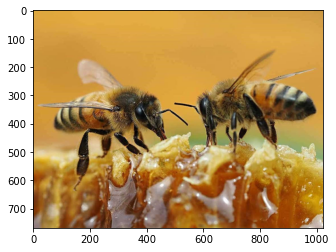

In [22]:
url = "https://www.beeculture.com/wp-content/uploads/2020/05/Buzz-1-2.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

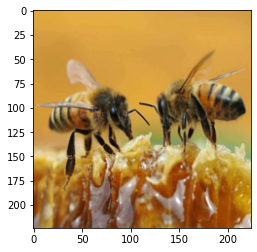

In [23]:
img_pred = transform(img)
plt.imshow(im_convert(img_pred))

In [24]:
img_input = img_pred.to(device).unsqueeze(0)
pred = model(img_input)
_, pred_label = torch.max(pred, 1)
class_names[pred_label.item()]

'bee'